In [1]:
import pandas as pd
import seaborn as sns
from skpsl import ProbabilisticScoringList
from matplotlib import pyplot as plt

dburl = ""

## psl influence on decision time

decision time on the 10 samples
- expert
- expert + psl

Normalized wrt. learning effect:
- plot decision times over time in phase 1 and 2
- check if the first couple of decisions are perhaps outliers.

<Axes: >

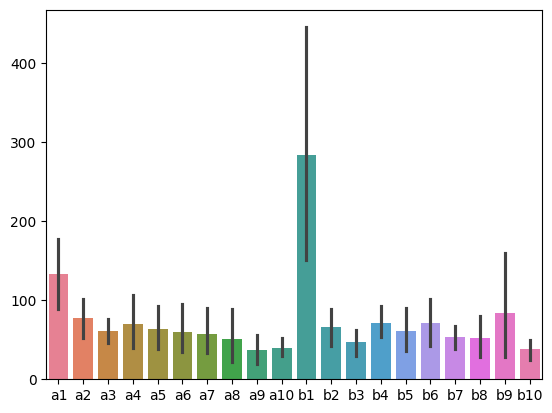

In [2]:
df = pd.read_csv("experiment/PageTimes-2024-09-11-processed.csv").filter(like="Assessment")
df.rename(columns=lambda col: f'a{1+int(col.split('_')[-1])}' if 'FirstAssessment' in col else f'b{1+int(col.split('_')[-1])}' if 'SecondAssessment' in col else col, inplace=True)
sns.barplot(df)

In [3]:
# cut of the first stage
df_ = df[[x for x in df.columns if "1" not in x]]
# average decision time across all participents and stages ommiting nan values
df_.stack().mean()

61.302083333333336

<Axes: xlabel='prefix', ylabel='value'>

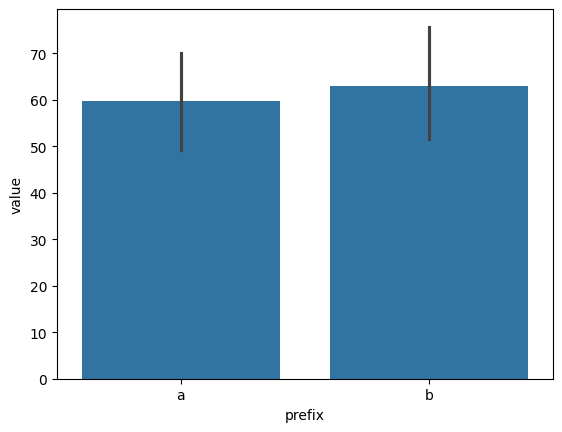

In [4]:

df_melted = pd.melt(df_, var_name='category', value_name='value')

# Create a new column to capture the prefix (e.g., 'a' or 'b')
df_melted['prefix'] = df_melted['category'].str[0]
sns.barplot(df_melted, x="prefix", y="value")

## Performance comparison

sample of 10 people
brier score of expert
brier score of expert + psl
brier score of datadriven psl

In [5]:
def fit_psl(dataset, features=None, scores=None, k="predef"):
    match dataset:
        case "schüler-ing-bin":
            data = pd.read_csv("dataset/schüler_pslvis_ERFOLG_train_ONLY_Ingenieur Studium_binary.csv")
        case "schüler-wiwi-bin":
            # this experiment "Dlh1Ug" has actually been done with the non-binary dataset, but was later relabeled
            data = pd.read_csv("dataset/schüler_pslvis_ERFOLG_train_ONLY_Rechts Wirtschafts Sozial Studium.csv")
        case "schüler-mathe-bin":
            data = pd.read_csv("dataset/schüler_pslvis_ERFOLG_train_ONLY_Mathe Natur Studium_binary.csv")
        case "schüler-*-bin":
            data = pd.read_csv("dataset/schüler_pslvis_ERFOLG_train_binary.csv")
        case _:
            raise ValueError()
    X = data.iloc[:, 1:]
    y = data.iloc[:, 0]

    psl = ProbabilisticScoringList({-3, -2, -1, 0, 1, 2, 3})
    if features is None:
        return psl.fit(X,y)
    scores = [scores[f_] for f_ in features]
   
    return psl.fit(X, y, predef_features=features, predef_scores=scores, k=k)


df = pd.read_csv("experiment/all_apps_wide-2024-09-16.csv")
df = df[df["participant._current_app_name"].notna()]

app_logentry = pd.read_sql_table("app_logentry", dburl)
app_pslparam = pd.read_sql_table("app_pslparam", dburl)
app_subject = pd.read_sql_table("app_subject", dburl)
app_dataset = pd.read_sql_table("app_dataset", dburl)
app_experiment = pd.read_sql_table("app_experiment", dburl)
app_dataexperimentsubj = app_dataset.merge(app_experiment, left_on="name", right_on="dataset_id").merge(app_subject, left_on="id", right_on="experiment_id", suffixes=("_experiment", "_subj") )
df_params = app_dataexperimentsubj[app_dataexperimentsubj['id_subj'].isin(df['study_students.1.player.pslvis_subject_id'])]
df_subj_ds = df_params[["id_subj", "dataset_id"]]
df_subj_ds = dict(df_subj_ds.values)
df_subj_ds

{'8NEtzA': 'schüler-ing-bin',
 'LN3JTA': 'schüler-ing-bin',
 'AX6jaw': 'schüler-ing-bin',
 'ZligBg': 'schüler-ing-bin',
 'Dlh1Ug': 'schüler-wiwi-bin',
 '7P-hCA': 'schüler-mathe-bin',
 'GGPALw': 'schüler-*-bin'}

In [6]:
brier = df.filter(regex=r".*brier|\.pslvis_subject_id")
brier.columns = ["subject_id", "phase1", "phase2"]
brier

scores = []
for subj in brier.subject_id:
    psl = fit_psl(df_subj_ds[subj])
    match df_subj_ds[subj]:
        case "schüler-ing-bin":
            data = pd.read_csv("dataset/schüler_pslvis_ERFOLG_sample_ONLY_Ingenieur Studium_binary.csv")
        case "schüler-wiwi-bin":
            # this experiment "Dlh1Ug" has actually been done with the non-binary dataset, but was later relabeled
            data = pd.read_csv("dataset/schüler_pslvis_ERFOLG_sample_ONLY_Rechts Wirtschafts Sozial Studium_binary.csv")
        case "schüler-mathe-bin":
            data = pd.read_csv("dataset/schüler_pslvis_ERFOLG_sample_ONLY_Mathe Natur Studium_binary.csv")
        case "schüler-*-bin":
            data = pd.read_csv("dataset/schüler_pslvis_ERFOLG_sample_binary.csv")
        case _:
            raise ValueError()

    X = data.iloc[:, 1:]
    y = data.iloc[:, 0]
    scores.append(psl.score(X,y,k=-1))
brier.insert(3,"reference", scores)
brier

,subject_id,phase1,phase2,reference
0,ZligBg,0.28664,0.28402,0.258986
1,8NEtzA,0.31909,0.22501,0.258986
2,LN3JTA,0.23675,0.24221,0.258986
3,Dlh1Ug,0.28710,0.24009,0.273635
4,AX6jaw,0.32824,0.25671,0.258986
5,GGPALw,0.14440,0.20282,0.288480
6,7P-hCA,0.25576,0.24768,0.248606


Text(0.5, 1.0, 'Brier score')

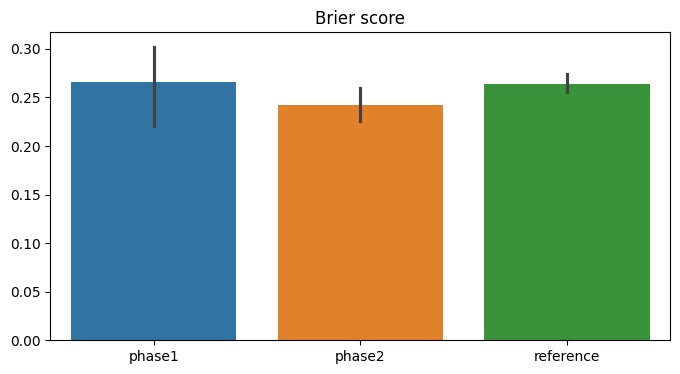

In [7]:
plt.figure(figsize=(8,4))
sns.barplot(brier.iloc[:,1:])
plt.title("Brier score")